In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
from twitter.twitter_collection import TwitterCollection
from data_pipelines.data_manipulation import DataManipulation
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = 'ignore', category = pd.errors.PerformanceWarning)
%matplotlib inline

Python-dotenv could not parse statement starting at line 11


In [2]:
from collections import Counter
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')
from nltk.corpus import stopwords   # python -m nltk.downloader stopwords // from commandline

stop = stopwords.words('english')
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re

[nltk_data] Downloading package stopwords to /home/kozan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
client_twitter = TwitterCollection()
df_btc = client_twitter.get_tweets_df('bitcoin', pathdf='../data/tweets_data/btc/', filedf='btc_tweets.csv')

Authentication Successfull


In [4]:
df_btc.head()

,created_at,text,source,name,username,location,verified,description
0,2022-11-24 09:19:09+00:00,If you got your #btc #eth stuck in #blo...,Twitter Web App,Okay Bears Sales,Virgini21645863,NaN,False,Free tag to ONLY moots.
1,2022-11-24 09:19:08+00:00,@KuWallet Download #KuCoinWallet and bet and w...,Twitter Web App,Albalooo,Albaloookhoshke,"so far , so close",False,We all have something that make us really happ...
2,2022-11-24 09:19:06+00:00,The current data for #deXit \n \nprice 0.0012 ...,dexitPriceBot2,deXit Price Bot 🤖,dexitPriceBot,deXit community,False,This is a bot for deXit blockchain shows the p...
3,2022-11-24 09:19:05+00:00,@cryptojack @AltGemsAlert My biggest #crypto b...,Twitter Web App,Stacey Mitchell,StablePump,NaN,False,"#web3 entrepreneur, dreamer, lifelong learner"
4,2022-11-24 09:19:05+00:00,What Do You Really Own in the Ownership Econom...,Agorapulse app,Richard Turrin,richardturrin,Shanghai,False,Author best seller: Cashless | Onalytica No. 4...


In [5]:
def cleaning_tweet_data(df: pd.DataFrame()):
    df_tweets = df.copy()
    df_tweets.dropna(inplace=True)
    if 'Unnamed: 0' in df_tweets.columns:
        df_tweets.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
    df_tweets.drop(columns=['source', 'name', 'location', 'verified', 'description'], axis=1, inplace=True)
    blanks = []  # start with an empty list

    for i, created_at, text, username in df_tweets.itertuples():  
        if type(text)==str:            
            if text.isspace():         
                blanks.append(i)    

    df_tweets.drop(blanks, inplace=True)
    df_tweets = df_tweets.apply(lambda x: x.astype(str).str.lower()).drop_duplicates(subset=['text', 'username'], keep='first')

    df_tweets['text'] = df_tweets['text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
    df_tweets['text'] = df_tweets['text'].str.lower()
    df_tweets['text'] = df_tweets['text'].str.replace("@[a-z0-9A-Z]+", "", regex=True)
    df_tweets['text'] = df_tweets['text'].str.replace("#[a-z0-9A-Z]+","", regex=True)
    df_tweets['text'] = df_tweets['text'].str.replace(r"http\S+", "")
    df_tweets['text'] = df_tweets['text'].str.replace(r"www.\S+", "")
    df_tweets['text'] = df_tweets['text'].str.replace('[()!?]', ' ')
    df_tweets['text'] = df_tweets['text'].str.replace('\[.*?\]',' ')
    df_tweets['text'] = df_tweets['text'].str.replace("[^a-z0-9]"," ")
    df_tweets['words'] = df_tweets['text'].apply(lambda x:str(x.lower()).split())

    df_tweets['tweet_without_stopwords'] = df_tweets['text'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in (stop)]))

    def remove_stopword(x):
        return [y for y in x if y not in stopwords.words('english')]
    df_tweets['words'] = df_tweets['words'].apply(lambda x:remove_stopword(x))

    def remove_hashtag(x):
        return [y for y in x if not y.startswith('#')]
    df_tweets['words'] = df_tweets['words'].apply(lambda x:remove_hashtag(x))

    return df_tweets

In [6]:
df_btc = cleaning_tweet_data(df_btc)

In [7]:
def preprocessing_tweet_datetime(df: pd.DataFrame()) -> pd.DataFrame():
    df_temp = df.copy()
    df_temp.drop(df_temp[df_temp.created_at == 'twitter'].index, inplace=True)
    df_temp.created_at = pd.to_datetime(df_temp.created_at)
    df_temp['Date'] = df_temp.created_at.apply(lambda x: x.date())
    df_temp['hour'] = df_temp.created_at.apply(lambda x: x.hour)
    df_temp['minute'] = df_temp.created_at.apply(lambda x: x.minute)
    return df_temp

In [8]:
df_btc = preprocessing_tweet_datetime(df_btc)

In [9]:
df_btc.tail()

,created_at,text,username,words,tweet_without_stopwords,Date,hour,minute
2055487,2022-10-16 16:20:28+00:00,3 day rsi 2018 vs 2022,mr_cryptonews,"[3, day, rsi, 2018, vs, 2022]",3 day rsi 2018 vs 2022,2022-10-16,16,20
2055490,2022-10-16 16:20:27+00:00,fate is hyperdeflationary multiple r...,crebbsmaynard,"[fate, hyperdeflationary, multiple, revenue, s...",fate hyperdeflationary multiple revenue stream...,2022-10-16,16,20
2055493,2022-10-16 16:20:26+00:00,is the future of world coming soon with 5...,bitconbot,"[future, world, coming, soon, 5m, dedicated, t...",future world coming soon 5m dedicated team 9 d...,2022-10-16,16,20
2055495,2022-10-16 16:20:26+00:00,buy today before the price explodes is hol...,whalesradar_com,"[buy, today, price, explodes, holding, prisone...",buy today price explodes holding prisoners way...,2022-10-16,16,20
2055496,2022-10-16 16:20:26+00:00,magical buy today before the price explodes ...,sirducutj,"[magical, buy, today, price, explodes, holding...",magical buy today price explodes holding priso...,2022-10-16,16,20


In [10]:
sid = SentimentIntensityAnalyzer()

In [11]:
def get_vader_sentiment(score):    
    if (score >= 0.05): 
        return "Positive"
    
    elif (score < 0.05 and score > -0.05):
        return "Neutral"
    
    elif (score <= -0.05):    
        return "Negative"
    
    return score

In [12]:
def get_sentiment_scores(df: pd.DataFrame()):
    df_temp = df.copy()
    df_temp['scores'] = df_temp['text'].apply(lambda review: sid.polarity_scores(review))
    df_temp['compound']  = df_temp['scores'].apply(lambda score_dict: score_dict['compound'])
    df_temp['comp_score'] = df_temp['compound'].apply(lambda score: get_vader_sentiment(score))
    return df_temp

In [13]:
df_btc = get_sentiment_scores(df_btc)
df_btc.head()

,created_at,text,username,words,tweet_without_stopwords,Date,hour,minute,scores,compound,comp_score
1,2022-11-24 09:19:08+00:00,download and bet and win use this link or s...,albaloookhoshke,"[download, bet, win, use, link, scan, qr, code]",download bet win use link scan qr code,2022-11-24,9,19,"{'neg': 0.0, 'neu': 0.759, 'pos': 0.241, 'comp...",0.5859,Positive
2,2022-11-24 09:19:06+00:00,the current data for price 0 0012 usd mar...,dexitpricebot,"[current, data, price, 0, 0012, usd, markcetca...",current data price 0 0012 usd markcetcap 0 0 u...,2022-11-24,9,19,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
4,2022-11-24 09:19:05+00:00,what do you really own in the ownership econom...,richardturrin,"[really, ownership, economy, governance, token...",really ownership economy governance tokens mak...,2022-11-24,9,19,"{'neg': 0.126, 'neu': 0.874, 'pos': 0.0, 'comp...",-0.3182,Negative
7,2022-11-24 09:19:01+00:00,black friday 10 off everything this offe...,nftsalon,"[black, friday, 10, everything, offer, valid, ...",black friday 10 everything offer valid whole w...,2022-11-24,9,19,"{'neg': 0.0, 'neu': 0.72, 'pos': 0.28, 'compou...",0.8271,Positive
8,2022-11-24 09:18:59+00:00,otto thomson matthew william ingrid jona...,firozmew11,"[otto, thomson, matthew, william, ingrid, jona...",otto thomson matthew william ingrid jonah edis...,2022-11-24,9,18,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral


In [14]:
df_btc['words'] = df_btc['tweet_without_stopwords'].apply(lambda x:str(x.lower()).split())
top = Counter([item for sublist in df_btc['words'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,0,4084
1,price,3922
2,1,2980
3,btc,2071
4,buy,1750
5,usd,1616
6,5,1613
7,last,1458
8,2,1318
9,n,1142


In [15]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=50, figure_size=(16.0,9.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud)
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()  

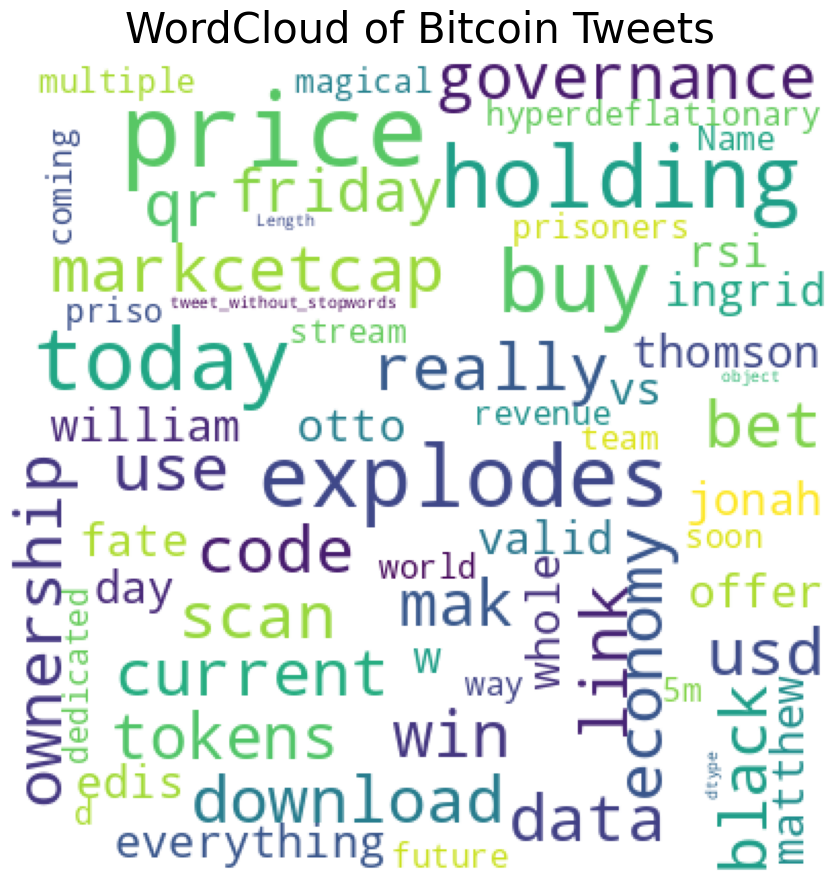

In [16]:
plot_wordcloud(df_btc['tweet_without_stopwords'],mask=None,color='white',max_font_size=50,title_size=30,title="WordCloud of Bitcoin Tweets")

In [17]:
df_btc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17459 entries, 1 to 2055496
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   created_at               17459 non-null  datetime64[ns, UTC]
 1   text                     17459 non-null  object             
 2   username                 17459 non-null  object             
 3   words                    17459 non-null  object             
 4   tweet_without_stopwords  17459 non-null  object             
 5   Date                     17459 non-null  object             
 6   hour                     17459 non-null  int64              
 7   minute                   17459 non-null  int64              
 8   scores                   17459 non-null  object             
 9   compound                 17459 non-null  float64            
 10  comp_score               17459 non-null  object             
dtypes: datetime64[ns, UTC](1),

<AxesSubplot:>

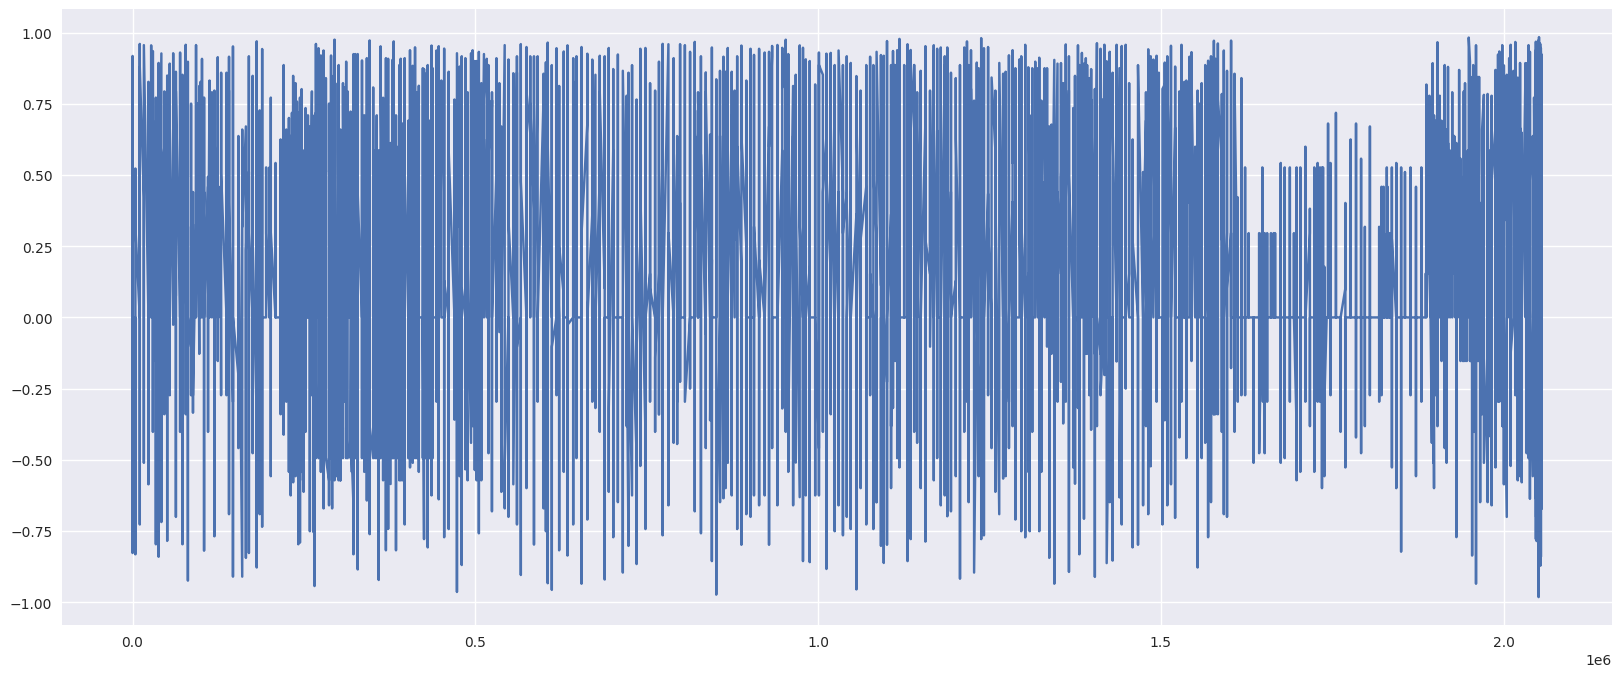

In [18]:
df_btc.compound.plot(x=df_btc.index, y=df_btc.compound,figsize=(20,8))

In [20]:
df_result = pd.DataFrame()
df_result['Date'] = df_btc.Date.unique()

In [21]:
df_result['compound_total'] = 0
for i, dt, com in df_result.itertuples():  
    sub_df = df_btc.loc[(df_btc.comp_score != 'Neutral'), :]
    df_result.loc[i, 'compound_total'] = sub_df.loc[(sub_df.Date.unique()[i] == sub_df.Date), 'compound'].mean()

In [22]:
df_result.tail()

,Date,compound_total
34,2022-10-20,0.4342
35,2022-10-19,0.4139
36,2022-10-18,0.4392
37,2022-10-17,0.0599
38,2022-10-16,-0.1756


In [23]:
df_result = df_result.sort_values('Date')

In [24]:
df_result.set_index('Date', inplace=True)

In [25]:
import yfinance as yf
ohlc = yf.download('BTC-USD', start='2022-10-16', end='2022-11-24')

[*********************100%***********************]  1 of 1 completed


Text(0, 0.5, 'Sentiment Score')

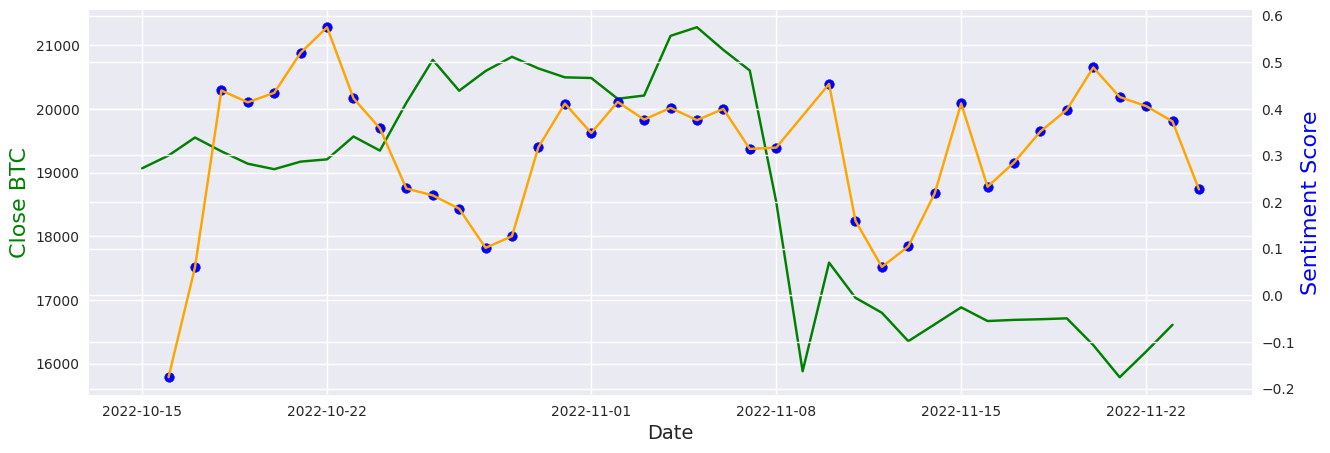

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(ohlc.index, ohlc.Close, color='green')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Close BTC', color='green', fontsize=16)

ax2 = ax.twinx()
ax2.scatter(df_result.index, df_result.compound_total, color='blue')
ax2.plot(df_result.index, df_result.compound_total, color='orange')
ax2.set_ylabel('Sentiment Score', color='blue', fontsize=16)

In [42]:
frames = [ohlc, df_result]
ohlc.shape

(40, 6)

In [50]:
result = ohlc.merge(df_result, how='outer', left_index=True, right_index=True)

In [51]:
result.head()

,Open,High,Low,Close,Adj Close,Volume,compound_total
Date,,,,,,,
2022-10-15,19185.4375,19212.5410,19019.2500,19067.6348,19067.6348,16192235532.0000,NaN
2022-10-16,19068.9141,19389.6035,19068.9141,19268.0938,19268.0938,17988916650.0000,-0.1756
2022-10-17,19268.5625,19635.8027,19173.3340,19550.7578,19550.7578,27472552998.0000,0.0599
2022-10-18,19550.4668,19666.9941,19144.7695,19334.4160,19334.4160,30580012344.0000,0.4392
2022-10-19,19335.0273,19348.4160,19127.6875,19139.5352,19139.5352,22425387184.0000,0.4139
